In [1]:
import pandahouse as ph
import pandas as pd
import numpy as np

In [4]:
connection = {'database':'default',
             'host': 'https://clickhouse.lab.karpov.courses',
             'user':'student',
             'password':'dpo_python_2020'}

In [3]:
query="""SELECT count(*)
FROM ldn_listings"""

In [4]:
ph.read_clickhouse(query, connection=connection)

,count()
0,85207


In [5]:
query2="""SELECT
id,
room_type,
replaceRegexpAll(price, '[$,]', '' ) AS price
FROM ldn_listings
LIMIT 1000"""

In [6]:
df=ph.read_clickhouse(query2,connection=connection)

In [7]:
df.price=df.price.astype(float)

In [8]:
df.dtypes

id            uint32
room_type     object
price        float64
dtype: object

In [25]:
df.groupby('room_type')['price'].quantile(q=0.75)

room_type
Entire home/apt    160.00
Hotel room         157.00
Private room        70.00
Shared room         69.25
Name: price, dtype: float64

In [37]:
query3="""SELECT 
room_type,
AVG(toFloat32OrNull(replaceRegexpAll(price, '[$,]', '' ))) AS price,
AVG(toFloat32OrNull(review_scores_rating)) AS score
FROM ldn_listings
GROUP BY room_type
LIMIT 1000
"""

In [38]:
df3=ph.read_clickhouse(query3, connection=connection)

In [12]:
import seaborn as sns

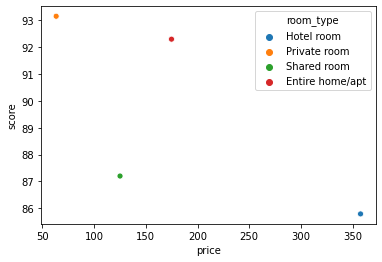

In [40]:
sns.scatterplot(x='price', y='score', data=df3, hue='room_type')

In [47]:
query4="""SELECT 
DISTINCT host_id,
host_verifications
FROM ldn_listings
WHERE experiences_offered != 'none'
"""

In [48]:
df4=ph.read_clickhouse(query4, connection=connection)

In [68]:
df4.host_verifications=df4.host_verifications.apply(lambda x: x.strip('[]').split(','))

In [72]:
df4.explode('host_verifications').host_verifications.value_counts()

 'phone'                    1345
'email'                     1345
 'reviews'                  1309
 'government_id'            1196
 'jumio'                    1115
 'offline_government_id'     469
 'work_email'                279
 'facebook'                  270
 'selfie'                    252
 'identity_manual'           227
 'manual_offline'             70
 'google'                     34
 'kba'                        27
'phone'                       16
 'manual_online'              16
 'sent_id'                     6
Name: host_verifications, dtype: int64

In [78]:
query5="""SELECT 
neighbourhood_cleansed,
experiences_offered,
Count(*) AS experiences_count
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed,
experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
"""

In [79]:
df5=ph.read_clickhouse(query5, connection=connection)

In [85]:
df5_1=df5.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

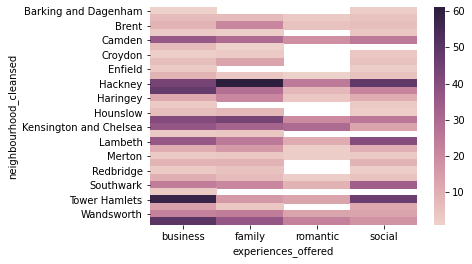

In [88]:
sns.heatmap(df5_1, cmap=sns.cubehelix_palette(as_cmap=True))

In [9]:
query6="""SELECT 
room_type,
toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
WHERE experiences_offered != 'none'
"""

In [10]:
df6=ph.read_clickhouse(query6, connection=connection)

In [11]:
df6.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


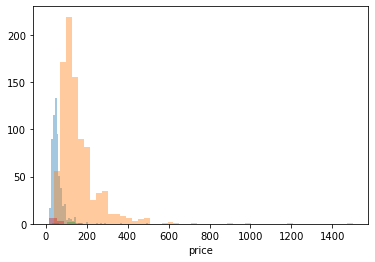

In [28]:
sns.distplot(df6[df6['room_type']=='Private room'].price, kde=False)
sns.distplot(df6[df6['room_type']=='Entire home/apt'].price, kde=False)
sns.distplot(df6[df6['room_type']=='Hotel room'].price, kde=False)
sns.distplot(df6[df6['room_type']=='Shared room'].price, kde=False)

In [31]:
import numpy as np
df6_log=df6

In [32]:
df6_log.price=df6_log.price.apply(lambda x: np.log(x))

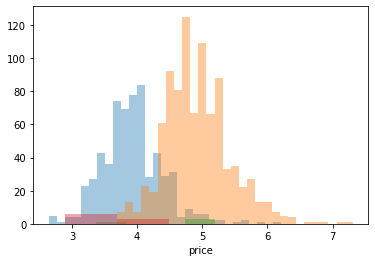

In [33]:
sns.distplot(df6_log[df6_log['room_type']=='Private room'].price, kde=False)
sns.distplot(df6_log[df6_log['room_type']=='Entire home/apt'].price, kde=False)
sns.distplot(df6_log[df6_log['room_type']=='Hotel room'].price, kde=False)
sns.distplot(df6_log[df6_log['room_type']=='Shared room'].price, kde=False)

In [30]:
df6_log

0       4.174387
1       4.605170
2       5.010635
3       3.806662
4       3.218876
          ...   
1543    4.605170
1544    4.828314
1545    5.220356
1546    4.700480
1547    3.663562
Name: price, Length: 1548, dtype: float64

In [36]:
query7="""SELECT 
room_type,
toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
CAST(first_review AS date) AS date
FROM ldn_listings
WHERE first_review>'2010-01-01'
LIMIT 1000
"""

In [37]:
df7=ph.read_clickhouse(query7, connection=connection)

In [43]:
df7.date=df7.date.dt.year

In [44]:
df7.date

0      2010
1      2011
2      2016
3      2010
4      2010
       ... 
995    2012
996    2013
997    2012
998    2012
999    2012
Name: date, Length: 1000, dtype: int64

In [46]:
df7.sort_values(by='date', inplace=True)

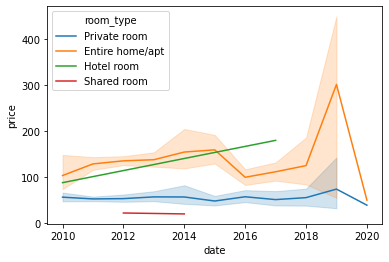

In [51]:
sns.lineplot(x='date', y='price', hue='room_type', data=df7)

In [50]:
df7

,room_type,price,date
0,Private room,65.0,2010
44,Private room,55.0,2010
39,Private room,75.0,2010
38,Entire home/apt,78.0,2010
33,Private room,45.0,2010
...,...,...,...
887,Private room,21.0,2019
277,Private room,105.0,2019
431,Private room,35.0,2019
12,Private room,39.0,2020
